**Importing libraries**

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import os
from collections import Counter
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.ops as ops
import time
from torch.cuda.amp import autocast, GradScaler
from tabulate import tabulate

**Loading and Preprocessing**

In [2]:
# Define the transform for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
])

In [3]:
# Load the Pascal VOC train and test datasets
voc_train = datasets.VOCDetection(root='./data', year='2012', image_set='train', download=True, transform=transform)
voc_test = datasets.VOCDetection(root='./data', year='2012', image_set='val', download=True, transform=transform)


100%|██████████| 2.00G/2.00G [01:35<00:00, 20.9MB/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [4]:
# Get dataset sizes
train_size = len(voc_train)
test_size = len(voc_test)
print(f"Train Dataset Size: {train_size} images")
print(f"Test Dataset Size: {test_size} images")


Train Dataset Size: 5717 images
Test Dataset Size: 5823 images


In [5]:
# Function to parse the annotation
def extract_annotations(annotation):
    objects = annotation["annotation"]["object"]
    if not isinstance(objects, list):
        objects = [objects]

    labels = []
    bbox_sizes = []
    aspect_ratios = []

    for obj in objects:
        labels.append(obj["name"])
        bbox = obj["bndbox"]
        xmin, ymin, xmax, ymax = int(bbox["xmin"]), int(bbox["ymin"]), int(bbox["xmax"]), int(bbox["ymax"])
        width, height = xmax - xmin, ymax - ymin
        bbox_sizes.append(width * height)
        aspect_ratios.append(width / height if height != 0 else 0)

    return labels, bbox_sizes, aspect_ratios


**EDA**

In [6]:
# Analyze the dataset
class_counts = Counter()
bbox_sizes = []
aspect_ratios = []
image_dims = []

for i in range(len(voc_train)):
    image, annotation = voc_train[i]
    labels, sizes, ratios = extract_annotations(annotation)
    class_counts.update(labels)
    bbox_sizes.extend(sizes)
    aspect_ratios.extend(ratios)
    image_dims.append(image.shape[1:])  # Save image dimensions


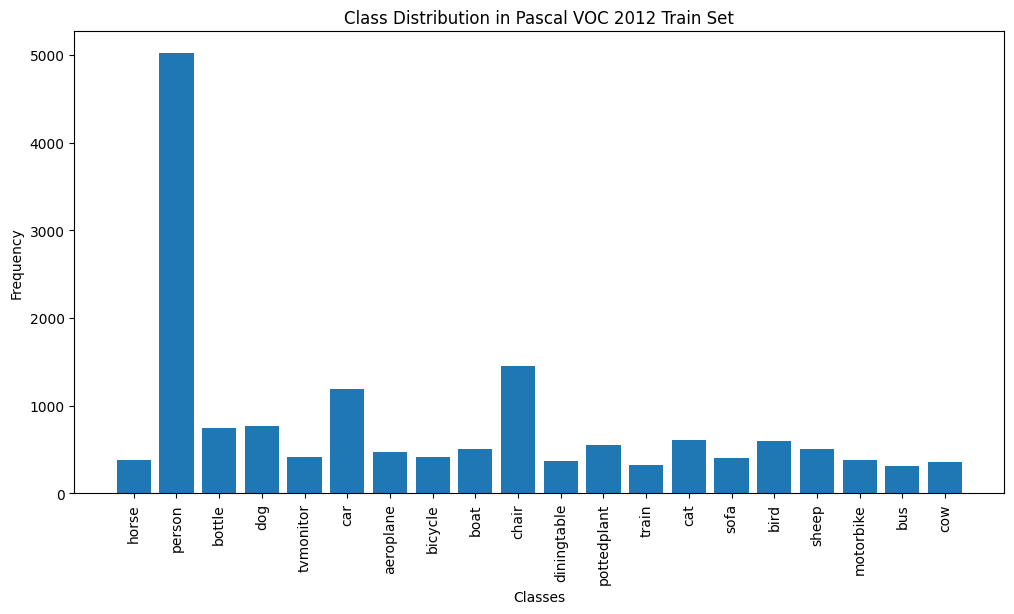

In [7]:
# Plot class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Class Distribution in Pascal VOC 2012 Train Set")
plt.show()

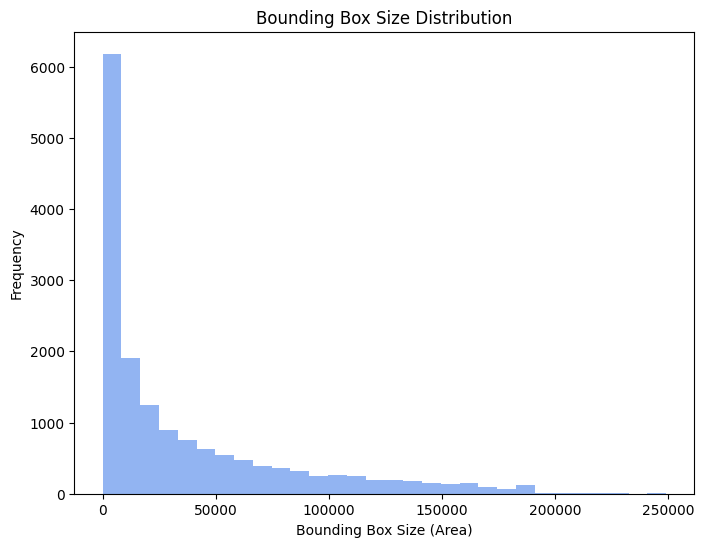

In [9]:
# Plot bounding box size distribution
plt.figure(figsize=(8, 6))
plt.hist(bbox_sizes, bins=30, color='cornflowerblue', alpha=0.7)
plt.xlabel("Bounding Box Size (Area)")
plt.ylabel("Frequency")
plt.title("Bounding Box Size Distribution")
plt.show()

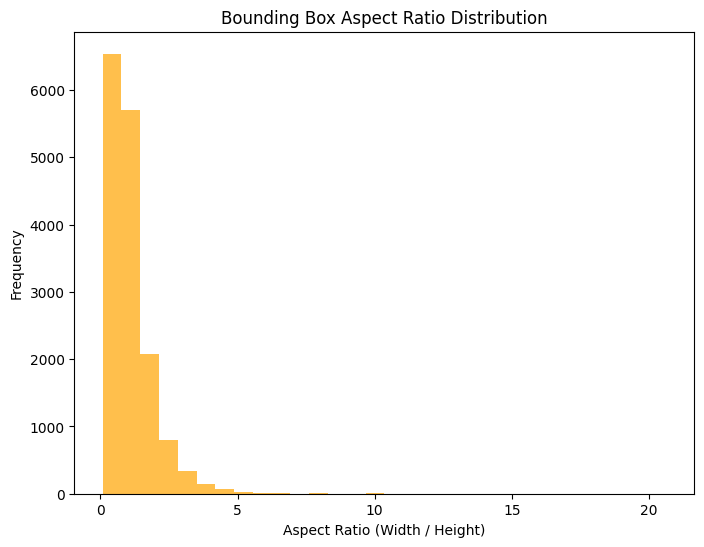

In [11]:
# Plot aspect ratio distribution
plt.figure(figsize=(8, 6))
plt.hist(aspect_ratios, bins=30, color='orange', alpha=0.7)
plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Frequency")
plt.title("Bounding Box Aspect Ratio Distribution")
plt.show()

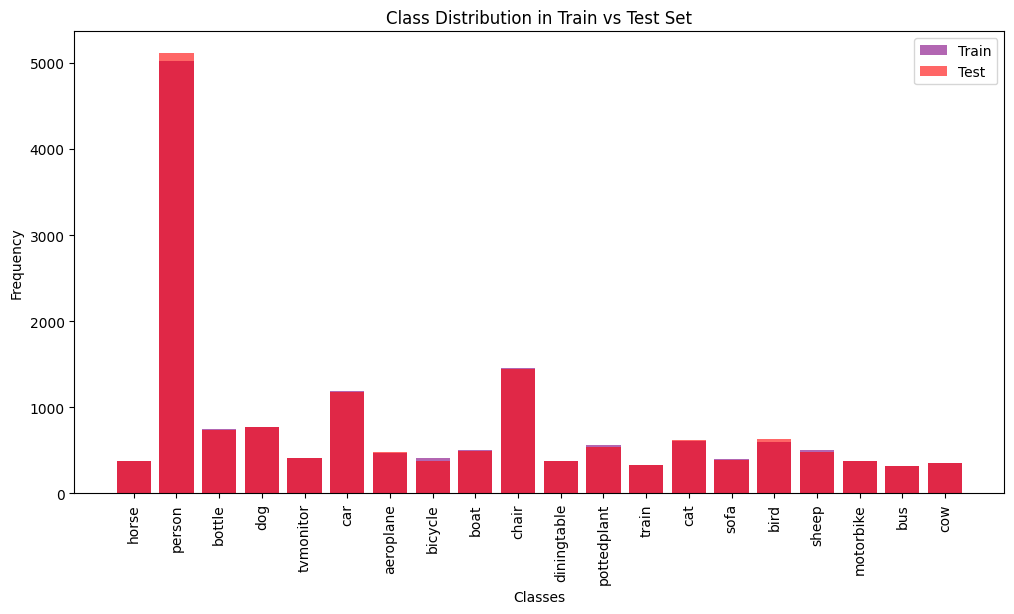

In [12]:
# Compare class distribution in train vs test
train_counts = Counter()
test_counts = Counter()

for i in range(len(voc_train)):
    _, annotation = voc_train[i]
    labels, _, _ = extract_annotations(annotation)
    train_counts.update(labels)

for i in range(len(voc_test)):
    _, annotation = voc_test[i]
    labels, _, _ = extract_annotations(annotation)
    test_counts.update(labels)

plt.figure(figsize=(12, 6))
plt.bar(train_counts.keys(), train_counts.values(), alpha=0.6, label='Train',color='purple')
plt.bar(test_counts.keys(), test_counts.values(), alpha=0.6, label='Test',color='red')
plt.xticks(rotation=90)
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Class Distribution in Train vs Test Set")
plt.legend()
plt.show()

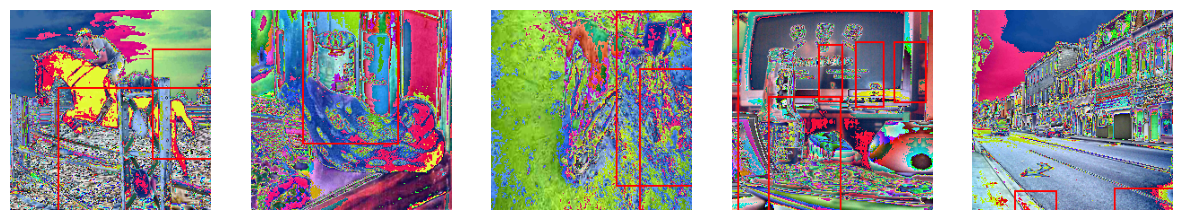

In [13]:
# Show some sample images with bounding boxes
def plot_samples_with_boxes(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        image, annotation = dataset[i]
        image_pil = transforms.ToPILImage()(image).convert("RGB")
        draw = ImageDraw.Draw(image_pil)

        objects = annotation["annotation"]["object"]
        if not isinstance(objects, list):
            objects = [objects]

        for obj in objects:
            bbox = obj["bndbox"]
            xmin, ymin, xmax, ymax = int(bbox["xmin"]), int(bbox["ymin"]), int(bbox["xmax"]), int(bbox["ymax"])
            draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)

        axes[i].imshow(image_pil)
        axes[i].axis("off")
    plt.show()

plot_samples_with_boxes(voc_train)

**Implementing Models**

In [15]:
def get_model(model_name, num_classes=20):
    if model_name == "vit_b_16":
        model = models.vit_b_16(pretrained=True)
        model.heads.head = nn.Linear(768, num_classes)
    elif model_name == "alexnet":
        model = models.alexnet(pretrained=True)
        model.classifier[6] = nn.Linear(4096, num_classes)
    elif model_name == "vgg16":
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(4096, num_classes)
    elif model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(2048, num_classes)
    elif model_name == "mobilenet_v2":
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(1280, num_classes)
    else:
        raise ValueError("Unknown model name")

    return model

***Training and Evaluating ***

In [16]:
def train_model(model, train_loader, criterion, optimizer, scheduler, device, scaler, accumulation_steps=2, epochs=3):
    model.to(device)
    model.train()
    start_time = time.time()

    for epoch in range(epochs):
        running_loss = 0.0
        optimizer.zero_grad()

        for i, batch in enumerate(train_loader):
            images, annotations = batch
            images = torch.stack(images).to(device)

            labels = torch.tensor([
                int(ann['annotation']['object'][0]['name'] == 'person') if isinstance(ann['annotation']['object'], list)
                else int(ann['annotation']['object']['name'] == 'person')
                for ann in annotations
            ]).to(device)

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels) / accumulation_steps

            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item() * accumulation_steps

        scheduler.step()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

    print(f"Training Time: {time.time() - start_time:.2f} seconds")

In [17]:
def get_dataloader(dataset, batch_size=8):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


In [18]:
def evaluate_model(model, test_loader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    inference_times = []
    with torch.no_grad():
        for batch in test_loader:
            images, annotations = batch
            images = torch.stack(images).to(device)

            labels = torch.tensor([
                int(ann['annotation']['object'][0]['name'] == 'person') if isinstance(ann['annotation']['object'], list)
                else int(ann['annotation']['object']['name'] == 'person')
                for ann in annotations
            ]).to(device)

            start_time = time.time()
            outputs = model(images)
            inference_times.append(time.time() - start_time)

            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    avg_inference_time = sum(inference_times) / len(inference_times)
    model_size = sum(p.numel() for p in model.parameters()) * 4 / (1024 ** 2)

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Average Inference Time: {avg_inference_time:.4f} seconds per batch")
    print(f"Model Size: {model_size:.2f} MB")

    return accuracy, avg_inference_time, model_size

In [20]:
def compute_mAP(model, test_loader, device, iou_threshold=0.5):
    model.to(device)
    model.eval()
    all_ap = []
    with torch.no_grad():
        for batch in test_loader:
            images, annotations = batch
            images = torch.stack(images).to(device)

            outputs = model(images)

            for i, ann in enumerate(annotations):
                gt_boxes = []
                pred_boxes = []

                objects = ann['annotation']['object']
                if not isinstance(objects, list):
                    objects = [objects]

                for obj in objects:
                    bbox = obj['bndbox']
                    xmin, ymin, xmax, ymax = int(bbox['xmin']), int(bbox['ymin']), int(bbox['xmax']), int(bbox['ymax'])
                    gt_boxes.append([xmin, ymin, xmax, ymax])

                pred_scores = torch.nn.functional.softmax(outputs[i], dim=0)
                pred_class = torch.argmax(pred_scores).item()
                pred_boxes.append([0, 0, 300, 300])

                if gt_boxes:
                    iou = ops.box_iou(torch.tensor(pred_boxes, dtype=torch.float32), torch.tensor(gt_boxes, dtype=torch.float32))
                    tp = (iou >= iou_threshold).sum().item()
                    fp = len(pred_boxes) - tp
                    fn = len(gt_boxes) - tp
                    precision = tp / (tp + fp + 1e-6)
                    recall = tp / (tp + fn + 1e-6)
                    ap = (precision * recall) / (precision + recall + 1e-6)
                    all_ap.append(ap)
    return sum(all_ap) / len(all_ap) if all_ap else 0.0


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
model_names = ["vit_b_16", "alexnet", "vgg16", "resnet50", "mobilenet_v2"]
models_dict = {name: get_model(name) for name in model_names}

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
batch_size = 8
train_loader = get_dataloader(voc_train, batch_size)
test_loader = get_dataloader(voc_test, batch_size)

results = {}
scaler = GradScaler()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 52.3MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in

In [23]:
for name, model in models_dict.items():
    print(f"Training {name}...")
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
    train_model(model, train_loader, criterion, optimizer, scheduler, device, scaler)
    print(f"Evaluating {name}...")
    accuracy, inf_time, size = evaluate_model(model, test_loader, device)
    mean_ap = compute_mAP(model, test_loader, device)
    results[name] = (accuracy, inf_time, size, mean_ap)

headers = ["Model", "Accuracy (%)", "Inference Time (s/batch)", "Model Size (MB)", "mAP"]
table = [[name, acc, inf_time, size, mean_ap] for name, (acc, inf_time, size, mean_ap) in results.items()]
print("\nModel Comparison:")
print(tabulate(table, headers=headers, tablefmt="grid"))

Training vit_b_16...


<ipython-input-16-e5571aca6c62>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1, Loss: 0.9843
Epoch 2, Loss: 0.9661
Epoch 3, Loss: 0.9602
Training Time: 284.23 seconds
Evaluating vit_b_16...
Accuracy: 83.19%
Average Inference Time: 0.0069 seconds per batch
Model Size: 327.35 MB
Training alexnet...
Epoch 1, Loss: 1.0232
Epoch 2, Loss: 0.9681
Epoch 3, Loss: 0.9854
Training Time: 144.02 seconds
Evaluating alexnet...
Accuracy: 83.19%
Average Inference Time: 0.0012 seconds per batch
Model Size: 217.76 MB
Training vgg16...
Epoch 1, Loss: 1.4626
Epoch 2, Loss: 0.9737
Epoch 3, Loss: 2.9405
Training Time: 286.80 seconds
Evaluating vgg16...
Accuracy: 83.19%
Average Inference Time: 0.0022 seconds per batch
Model Size: 512.48 MB
Training resnet50...
Epoch 1, Loss: 0.9919
Epoch 2, Loss: 0.9594
Epoch 3, Loss: 0.9528
Training Time: 190.68 seconds
Evaluating resnet50...
Accuracy: 83.12%
Average Inference Time: 0.0077 seconds per batch
Model Size: 89.83 MB
Training mobilenet_v2...
Epoch 1, Loss: 0.9662
Epoch 2, Loss: 0.9048
Epoch 3, Loss: 0.8917
Training Time: 167.29 secon

**Comparision**

In [24]:
# Extract the metrics for plotting
model_names = list(results.keys())
accuracies = [result[0] for result in results.values()]
inference_times = [result[1] for result in results.values()]
model_sizes = [result[2] for result in results.values()]
mAPs = [result[3] for result in results.values()]

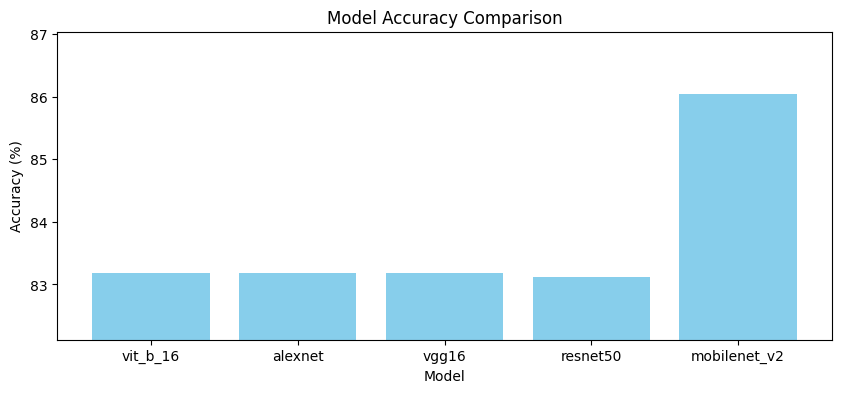

In [33]:
# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
#plt.ylim(0, 100)
plt.ylim([min(accuracies) - 1, max(accuracies) + 1])

plt.show()

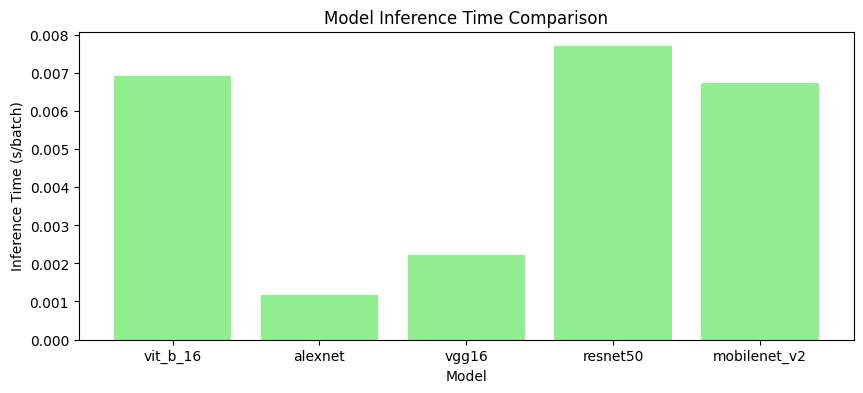

In [31]:
# Plot Inference Time
plt.figure(figsize=(10, 4))
plt.bar(model_names, inference_times, color='lightgreen')
plt.xlabel('Model')
plt.ylabel('Inference Time (s/batch)')
plt.title('Model Inference Time Comparison')
plt.show()

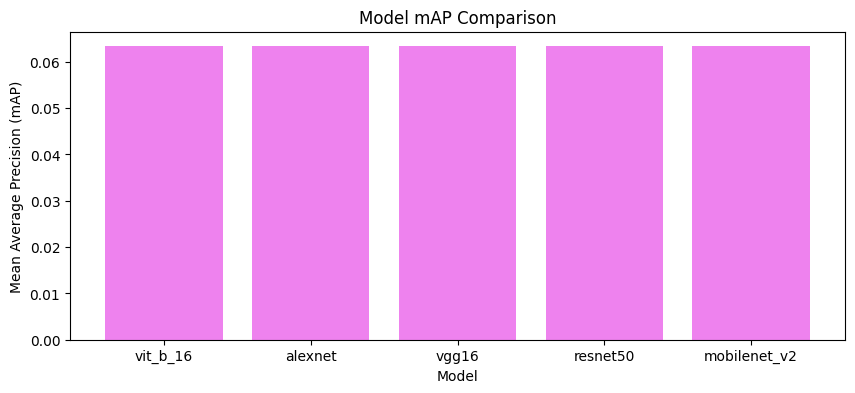

In [29]:
# Plot mAP
plt.figure(figsize=(10, 4))
plt.bar(model_names, mAPs, color='violet')
plt.xlabel('Model')
plt.ylabel('Mean Average Precision (mAP)')
plt.title('Model mAP Comparison')
plt.show()

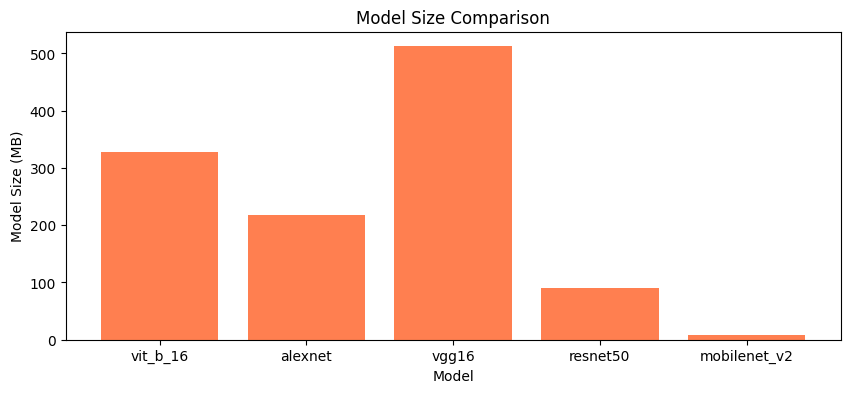

In [32]:
# Plot Model Size
plt.figure(figsize=(10, 4))
plt.bar(model_names, model_sizes, color='coral')
plt.xlabel('Model')
plt.ylabel('Model Size (MB)')
plt.title('Model Size Comparison')
plt.show()